### BERT 후속 모델로 영화 리뷰 텍스트의 감성 분류하기 목차
* [Chapter 1 BERT의 성능 개선 모델 - RoBERTa)](#chapter1)
* [Chapter 2 KerasNLP로 RoBERTa 모델만들기](#chapter2)
* [Chapter 3 RoBERTa 모델 미세튜닝](#chapter3)
* [Chapter 4 BERT의 경량화 모델 - DistilBERT](#chapter4)

### Chapter 1 BERT의 성능 개선 모델 - RoBERTa <a class="anchor" id="chapter1"></a>
1. RoBERTa 소개
   - BERT의 사전학습 방법을 개선한 모델
   - BERT는 모든 에코그에서 마스킹하는 단어가 동일한 정적 마스킹사용, RoBERTa는 매 에포크마다 마스킹하는 단어가 달라지는 동적 마스킹 사용 
   - BERT는 문장 2개를 입력받아 다음 문장 예측을 수행하는데, RoBERTa는 문장 1개만 입력받아 다음 문장 예측을 수행하지 않음
      - 다음문장 예측(NSP, Next Sentence Prediction) 작업이 문장 이해 능력 향상에 큰 도움이 되지 않는다는 연구 결과가 있었음
      - 문장을 구분하기 위한 세그먼트 아이디가 필요하지 않음
   - BERT는 위키피디아와 북코퍼스 데이터로 사전학습을 수행했는데, RoBERTa는 여기에 추가로 CC-NEWS, OPENWEBTEXT, STORIES 데이터셋을 사용하여 더 많은 양의 데이터로 사전학습을 수행함
   - BERT보다 더 큰 배치 크기와 더 긴 학습 시간으로 사전학습을 수행함
   - BERT보는 워드피스 토크나이저를 사용했는데, RoBERTa는 페이스북에서 개발한 BPE(Byte Pair Encoding) 토크나이저를 사용함
      - BPE는 어휘사전의 최대 크기에 도달할 때까지 말뭉치에서 가장 빈번하게 등장하는 부분단어를 새로운 토큰으로 추가한다.
      - BPE는 바이트를 기준으로 어휘사전을 만든다.

2. RoBERTa, BERT 비교
   - 입력에서 세그먼트 임베딩 삭제
   - tanh 활성화 함수를 가진 밀집층이 백본에서 제거됨

   ![BERT_RoBERTa](image/04-03-BERT_RoBERTa.png)     

   - RoBERTa는 Base, Large 모델이 존재


### Chapter 2 KerasNLP로 RoBERTa 모델만들기 <a class="anchor" id="chapter2"></a>

In [20]:
import keras
from keras import layers
import keras_nlp

def transformer_encoder(x, padding_mask, dropout, activation='relu'):
     residual = x
     key_dim = hidden_dim // num_heads
     
     # 배치에 있는 샘플 시퀸스 길이가 다른 경우, 짧은 시퀴스에 0 패딩을 추가하여 동일하게 맞춤
     # padding_mask: 0 패딩을 무시하기 위해 1과 0으로 이루어진 마스크
     x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query=x, value=x, attention_mask=padding_mask)
     
     # 잔차 드롭아웃: 스킵 연결 직전에 통과하는 드롭아웃 층
     x = layers.Dropout(dropout)(x)
     
     # 스킵 연결: 입력을 출력에 더해줌
     x = x + residual
     x = layers.LayerNormalization()(x)
     residual = x
     
     # 두 개의 밀집층으로 이루어진 피드 포워드 신경망
     x = layers.Dense(hidden_dim * 4, activation=activation)(x)
     x = layers.Dense(hidden_dim)(x)
     x = layers.Dropout(dropout)(x)
    
     x = x + residual
     x = layers.LayerNormalization()(x)
     return x

In [3]:
import keras
from keras import layers
import keras_nlp

# RoBERTa 백본
vocab_size = 50265 # RoBERTa 어휘사전 크기
num_layers = 12 # 트랜스포머 인코더 블록 개수
num_heads = 12 # 어텐션 헤드 개수
hidden_dim = 768 # 은닉층 크기
dropout = 0.1 # 드롭아웃 비율
activation = 'gelu' # 활성화 함수
max_seq_len = 512 # 최대 문장 길이

token_ids = keras.Input(shape=(None,)) # 토큰 아이디 입력, 세그먼트아이디 삭제
padding_mask = keras.Input(shape=(None,)) # 패딩 마스크 입력

# 토큰 임베딩 층
token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids) 

# 위치 임베딩 층
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

# 토큰 임베딩과 위치 임베딩을 더함
x = layers.Add()([token_embedding, pos_embedding])

# 정규화 실행
x = layers.LayerNormalization(epsilon=1e-6)(x) 

# 드롭아웃 적용
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)
    
outputs = x # 마지막 인코더의 출력 다음에 등장하는 밀집층 삭제

roberta_model = keras.Model(inputs=[token_ids, padding_mask], outputs=outputs)
roberta_model.summary()

I0000 00:00:1759632371.824964   17711 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5555 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 768) │ 38,603,520 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding[0][0],  │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 124,052,736 (473.22 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
import os
import keras
import tensorflow as tf
import keras_nlp
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
	try:
		# Set memory growth to True first
		tf.config.experimental.set_memory_growth(gpus[0], True)
		# Then set virtual device configuration (memory limit)
		tf.config.experimental.set_virtual_device_configuration(
			gpus[0],
			[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20144)] # 20GB limit
		)
	except RuntimeError as e:
		print(e)
	except ValueError as e:
		print("ValueError:", e)

#Keras version: 3.11.3
#TensorFlow version: 2.19.0
#Keras NLP version: 0.22.2
#compute capability: 8.6

# conda create -n CUDA7 python=3.9 
# activate CUDA7
# conda install -c anaconda keras
# pip install keras-nlp

print("Keras version: "+keras.__version__)
print("TensorFlow version: "+tf.__version__)
print("Keras NLP version: "+keras_nlp.__version__)
print(device_lib.list_local_devices() )

2025-10-05 12:47:51.845587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759636071.917176    1489 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759636071.939416    1489 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759636072.082110    1489 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759636072.082135    1489 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759636072.082137    1489 computation_placer.cc:177] computation placer alr

Keras version: 3.11.3
TensorFlow version: 2.19.0
Keras NLP version: 0.22.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17393992702660823661
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5824839680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16901231820496429378
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1759636076.371271    1489 gpu_device.cc:2019] Created device /device:GPU:0 with 5555 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


In [2]:
# KerasNLP에서 사전에 훈련된 RoBERTa 분류 모델 불러오기
roberta_classifier = keras_nlp.models.RobertaClassifier.from_preset("roberta_base_en", num_classes=2)
roberta_classifier.summary()

I0000 00:00:1759636266.686011    1489 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5555 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:08:00.0, compute capability: 8.6


Preprocessor: "roberta_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)                          │                       Vocab size: 50,265 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "roberta_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,866 (475.48 MB)

 Trainable params: 124,644,866 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# RoBERTa 모델의 토크나이져 로드
roberta_tokenizer = roberta_classifier.preprocessor.tokenizer

# 샘플 텍스트 --> 토큰아이디 --> 각 토큰에 대응하는 문자열로 변환
token_ids = roberta_tokenizer.tokenize("pandemonium is a horror movie")
for id in token_ids:
    print(roberta_tokenizer.id_to_token(id), end=' ')
    
# pandemonium
#    - BERT: pan, de, monium
#    - RoBERTa: p, an, de, monium

p and emonium Ġis Ġa Ġhorror Ġmovie 

### Chapter 3 RoBERTa 모델 미세튜닝 <a class="anchor" id="chapter3"></a>

In [4]:
# 훈련 데이터와 검증 데이터, 테스트 데이터를 텐서플로우 데이터셋으로 읽어드림
train_ds, val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=4,
    validation_split=0.2,
    subset="both",
    seed=42
)

# 테스트 데이터셋 읽어오기
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=4)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


1. 사전 훈련된 케라스 모델은 optimizer 속성에 훈련에 사용된 옵티마이저 객체를 저장하고 있다.
   - 1억 개가 넘는 파라미터를 가지고 있다.
   - 상대적으로 작은 크기의 IMDB 데이터셍으로 미세튜닝을 할 경우, 모델이 금방 과대적합될 가능성이 있다.
   - 따라서 옵티마이저의 학습률을 아주 작게 설정하여 모델이 급격하게 변하지 않도록 해야 한다.

In [5]:
roberta_classifier.optimizer.learning_rate.assign(5e-6) # 옵티마이저의 학습률을 아주 작게 설정  

<tf.Tensor: shape=(), dtype=float32, numpy=4.999999873689376e-06>

In [6]:
# 조기 종료 콜백 함수
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5, # 3 에포크 동안 개선되지 않으면 종료
    restore_best_weights=True) # 가장 낮은 검증 손실을 기록한

# 모델 훈련
hist = roberta_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stopping_cb])

Epoch 1/5


I0000 00:00:1759636357.289575    2299 service.cc:152] XLA service 0x7df088005150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759636357.289625    2299 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-10-05 12:52:37.908031: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759636360.823897    2299 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-10-05 12:52:45.189971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_277', 240 bytes spill stores, 240 bytes spill loads

2025-10-05 12:52:45.291162: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2

   1/5000 ━━━━━━━━━━━━━━━━━━━━ 72:18:28 52s/step - loss: 0.7069 - sparse_categorical_accuracy: 0.5000

I0000 00:00:1759636393.754592    2299 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 662s 122ms/step - loss: 0.1972 - sparse_categorical_accuracy: 0.9214 - val_loss: 0.1459 - val_sparse_categorical_accuracy: 0.9466
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 608s 121ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.1605 - val_sparse_categorical_accuracy: 0.9470
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 608s 121ms/step - loss: 0.0699 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.1952 - val_sparse_categorical_accuracy: 0.9404
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 609s 122ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.1776 - val_sparse_categorical_accuracy: 0.9468
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 613s 122ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.2053 - val_sparse_categorical_accuracy: 0.9432


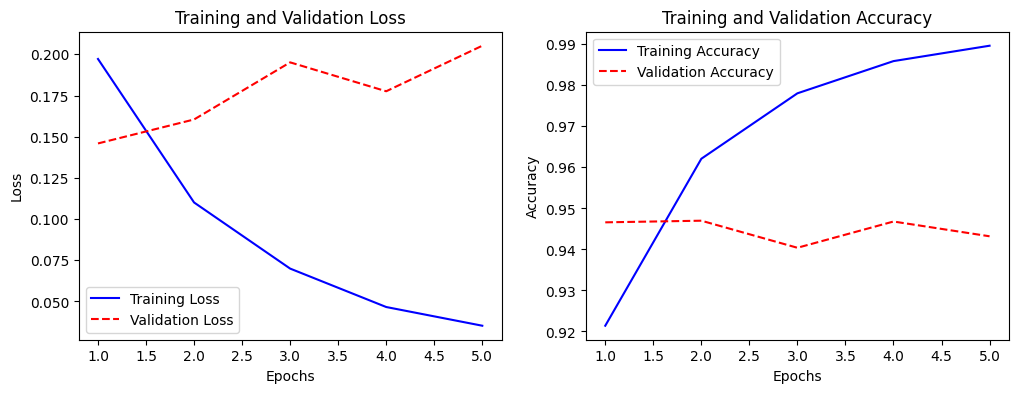

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  
axs[0].plot(epochs, hist.history['loss'], 'b-', label='Training Loss')
axs[0].plot(epochs, hist.history['val_loss'], 'r--', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, hist.history['sparse_categorical_accuracy'], 'b-', label='Training Accuracy')
axs[1].plot(epochs, hist.history['val_sparse_categorical_accuracy'], 'r--', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

# 에포크가 계속될수록 검증 세트의 성능은 조금씩 향상되지만 손실 값이 줄어들지 못해 조기종료됨
#   - 학습율을 낮추거나, earlystopping의 patience를 늘리거나, 배치 크기를 줄이는 방법으로 조기 종료해결 가능

In [9]:
roberta_classifier.evaluate(test_ds)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 198s 31ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9535


[0.12894727289676666, 0.9535199999809265]

### Chapter 4 BERT의 경량화 모델 - DistilBERT <a class="anchor" id="chapter4"></a>
1. DistilBERT 소개
   - BERT 모델을 경량화한 모델
   - BERT 모델의 크기를 줄이고 추론 속도를 높이기 위해 개발됨
   - BERT 모델의 절반 크기, 60%의 속도로 동작하면서도 BERT 모델 성능의 97%를 유지함
   - 지식 증류(knowledge distillation)라는 기술을 사용하여 BERT 모델을 압축함
      - 지식 증류는 큰 모델(teacher model)의 예측을 작은 모델(student model)이 학습하도록 하는 방법
      - 작은 모델이 큰 모델의 출력을 모방하도록 훈련하여, 작은 모델이 큰 모델의 출력에 가까워지도록 훈련하는 것이 핵심
   - DistilBERT는 BERT의 트랜스포머 층 수를 절반으로 줄이고, 각 층의 히든 유닛 수와 어텐션 헤드 수를 동일하게 유지함
   - BERT에서 사용된 마스킹 언어 모델링(MLM)과 양방향 문맥 학습을 그대로 유지함

In [21]:
import keras
from keras import layers
import keras_nlp

# BERT 베이스 MLM
vocab_size = 30522 # BERT 베이스 어휘사전 크기
num_layers = 12 # 트랜스포머 인코더 블록 개수
num_heads = 12 # 어텐션 헤드 개수
hidden_dim = 768 # 은닉층 크기
dropout = 0.1 # 드롭아웃 비율
activation = 'gelu' # 활성화 함수
max_seq_len = 512 # 최대 문장 길이

token_ids = keras.Input(shape=(None,)) # 토큰 아이디 입력
segment_ids = keras.Input(shape=(None,)) # 세그먼트 아이디 입력
padding_mask = keras.Input(shape=(None,)) # 패딩 마스크 입력
mlm_positions = keras.Input(shape=(None,)) # 마스킹된 토큰 위치 입력

# 토큰 임베딩 층 
#    - ReversibleEmbedding: 입력을 은닉 차원으로 바꾸는 보통의 임베딩 기능 외에 은닉 차원을 거꾸로 입력차원으로 변환할 수 있다.
token_embedding_layer = keras_nlp.layers.ReversibleEmbedding(vocab_size, hidden_dim)
token_embedding = token_embedding_layer(token_ids)

# 위치 임베딩 층
#   - PositionEmbedding: 입력 시퀀스의 각 위치에 대해 고유한 임베딩 벡터를 학습
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

# 세그먼트 임베딩 층
#   - 세그먼트 아이디는 문장이 두 개 이상일 때 각 문장을 구분하기 위해 사용
seg_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding)) # 세 임베딩을 더함
x = layers.LayerNormalization(epsilon=1e-6)(x) # 정규화 실행
x = layers.Dropout(dropout)(x) # 드롭아웃 적용

# 트랜스포머 인코더 블록을 num_layers 개수만큼 쌓음
for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

# mlm_position의 크기와 입력 차원 x의 크기를 맞추기 위해 마지막에 차원 추가    
mlm_position = keras.ops.expand_dims(mlm_positions, axis=-1) # 마스킹된 토큰 위치를 확장

# 입력 x에서 mlm_position에 있는 원소를 선택해서 반환
#   - 지정된 위치(마스킹된 단어의 위치)의 출력만 추출
x = keras.ops.take_along_axis(x, mlm_position, axis=1) # 마스킹된 토큰 위치에 해당하는 은닉 상태를 추출

x = layers.Dense(hidden_dim, activation=activation)(x) # 밀집층
x = layers.LayerNormalization(epsilon=1e-6)(x) # 정규화 실행
outputs = token_embedding_layer (x, reverse=True) # ReversibleEmbedding 층을 거꾸로 통과시켜 원래의 토큰 아이디 차원으로 변환

# 최종 모델
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask, mlm_positions), outputs=outputs)


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reversible_embeddi… │ (None, None,      │ 23,440,896 │ input_layer_28[0… │
│ (ReversibleEmbeddi… │ 30522)            │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 768) │    393,216 │ reversible_embed… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 768) │      1,536 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ reversible_embed… │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, None, 768) │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_30[0… │
│ (MultiHeadAttentio… │                   │            │ dropout_13[0][0], │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, None, 768) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 768) │          0 │ dropout_15[0][0], │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, None, 768) │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,483,776 (417.65 MB)

 Trainable params: 109,483,776 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(outputs.shape) # (배치크기, 마스킹된 토큰 개수, 어휘사전 크기)

(None, None, 30522)


2. DistilBERT는 지식 증류를 위해 세 가지 손실 함수를 사용함
    - 크로스 엔트로피(MLM loss)
        - 훈련 데이터의 타깃 값을 사용해 스튜던트 모델을 훈련하기 위한 손실함수
    - 정제 손실(distillation loss)
        - 티처 모델의 예측을 스튜던트 모델이 모방하도록 하는 손실 함수
        - 스튜던트 모델의 출력이 티처 모델의 출력에 가까워지도록 훈련하는 과정에서 사용됨
    - Cosine 손실(cosine loss)
        - 티처 모델과 스튜던트 모델의 트랜스포머 블록의 마지막 출력이 같아지도록 하는 함수
        - 스튜던트 모델이 티처 모델의 내부 표현을 더 잘 학습하도록 돕는 역할을 함
    - 최종 손실 함수는 세 가지 손실 함수의 가중 합으로 구성됨
    - DistilBERT는 BERT보다 적은 수의 파라미터로도 높은 성능을 유지할 수 있어, 모바일 및 엣지 디바이스에서의 활용에 적합함

3. 정제 손실
   - 티처 모델과 스튜던트 모델의 출력 값을 소프트맥스 함수에 통과시켜 확률 분포로 변환한 뒤 비교
   - 쿨백-라이블러 발산(KL Divergence)이라는 측정 방법을 사용하여 두 확률 분포 간의 차이를 계산
      - teacher_prd = softmax(teacher_output)
      - student_prd = softmax(student_output)
      - KLD_loss = teacher_prd * log(teacher_prd / student_prd) # 확률분포간 차이계산
    - 티처와 스튜던트의 출력 값이 같다면 손실은 0이 되고, 스튜던트 모델이 티쳐모델을 완벽하게 모방한 상태
    - 소프트멕스 계산에서 온도 매개변수(temperature parameter)를 사용하여 확률 분포를 부드럽게 만듦
      - 온도가 높을수록 확률 분포가 더 부드러워지고, 낮을수록 더 뾰족해짐
      - 온도가 높으면 모델이 덜 확신하는 예측을 하게 되어, 스튜던트 모델이 티처 모델의 출력을 더 잘 모방할 수 있음
      - 일반적으로 2에서 20 사이의 값을 사용함

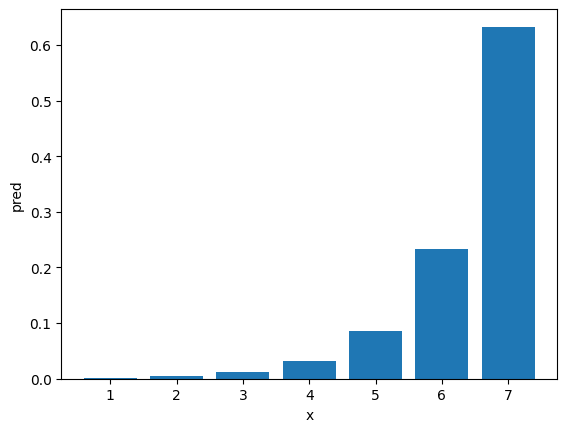

In [ ]:
from scipy.special import softmax

x = np.array([1, 2, 3, 4, 5, 6, 7])
prd = softmax(x)

plt.bar(x, prd)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

# 출력 값의 합이 1인 결과 출력
# 6과 7의 활률 차이는 0.3 이상
# 이러한 출력에서 랜덤하게 하나의 결과를 선택한다면 7이될 가능성이 높음

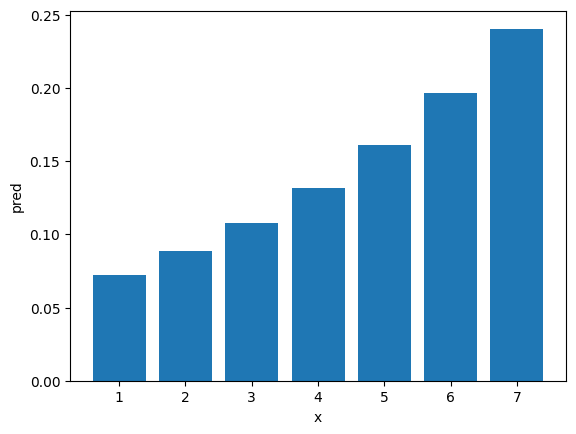

In [ ]:
pred = softmax(x/5)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

# x/5로 나누어 확률 분포를 평탄하게 만듦
# 6과 7의 확률 차이가 0.05로 줄어듦
# 이러한 출력에서 랜덤하게 하나의 결과를 선택한다면 다른 숫자가 선택될 가능성이 충분해진다.
# 다양성이 증가한다.

4. 정제 손실의 목적은 스튜던트 모델의 출력이 티쳐 모델의 출력과 같아지도록 만든는 것이다.
   - 정제 손실을 측정하는 쿨백-리이블러 발산을 줄이려면 두 모델의 출력 중 값이 큰 확률에 우선 맞추는 것이 유리하다.
   - 티처 모델의 다른 예측에도 유용한 정보가 담겨 있을 수 있기 때문에 이런 정보를 놓치지 않기 위해 온도 파라미터로 확률의 차이를 출이 후 정제손실을 계산한다.

5. DistilBERT와 RoBERTa 비교
   - DistilBERT는 BERT 모델을 경량화한 모델이고, RoBERTa는 BERT 모델의 사전학습 방법을 개선한 모델이다.
   - 분류기 시작 부분에 드롭아웃이 없다.
   - 첫 번째 밀집층의 활성화 함수로 tanh 대신 ReLU를 사용한다.

   ![DistilBERT와 RoBERTa](image/04-03-RoBERTa_DistilBERT.png) 



In [28]:
distil_bert_classifier = keras_nlp.models.DistilBertClassifier.from_preset("distil_bert_base_en", num_classes=2)

100%|██████████| 462/462 [00:00<00:00, 1.15MB/s]


100%|██████████| 249M/249M [00:14<00:00, 18.3MB/s] 


100%|██████████| 795/795 [00:00<00:00, 2.16MB/s]


100%|██████████| 208k/208k [00:00<00:00, 246kB/s]


In [29]:
distil_bert_classifier.summary()

Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 28,996 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      65,190,912 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 65,783,042 (250.94 MB)

 Trainable params: 65,783,042 (250.94 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from transformers import pipeline

# DistilBERT 모델을 사용한 문장 완성 파이프라인
pipe = pipeline("fill-mask",device=0, model="distilbert/distilbert-base-uncased")

pipe('The goal of life is [MASK].')

Device set to use cuda:0


[{'score': 0.036191657185554504,
  'token': 8404,
  'token_str': 'happiness',
  'sequence': 'the goal of life is happiness.'},
 {'score': 0.030553534626960754,
  'token': 7691,
  'token_str': 'survival',
  'sequence': 'the goal of life is survival.'},
 {'score': 0.01697717234492302,
  'token': 12611,
  'token_str': 'salvation',
  'sequence': 'the goal of life is salvation.'},
 {'score': 0.016698447987437248,
  'token': 4071,
  'token_str': 'freedom',
  'sequence': 'the goal of life is freedom.'},
 {'score': 0.015267278999090195,
  'token': 8499,
  'token_str': 'unity',
  'sequence': 'the goal of life is unity.'}]

In [31]:
# 허깅페이스 페이지에서 로튼 토마토 리뷰로 구성된 감성 분석 데이터셋인 SST-2에서 미세 튜닝된 모델로 감성 분석 시행
pipe = pipeline("text-classification", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")
pipe('The movie is a bit boring and easy to guess.')

Device set to use cuda:0


[{'label': 'NEGATIVE', 'score': 0.9996893405914307}]

In [33]:
from datasets import load_dataset

ds = load_dataset("imdb")

print(ds)

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 318921.13 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [34]:
# 테스트 데이터를 1000개만 무작위로 추출
test_slice = ds['test'].shuffle(seed=42).select(range(1000))

In [ ]:
from evaluate import evaluator

# text-classification : 텍스트 분류를 위한 평가기 생성
take_evaluator = evaluator("text-classification")

# 미세 튜닝된 DistilBERT 모델로 테스트 데이터의 감성 분류 정확도 평가
take_evaluator.compute(
    model_or_pipeline=pipe, 
    data=test_slice,
    metric="accuracy",
    input_column="text",
    label_column="label",  
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
)

{'accuracy': 0.881,
 'total_time_in_seconds': 7.935626243000115,
 'samples_per_second': 126.01399932136212,
 'latency_in_seconds': 0.007935626243000116}